In [4]:
import sys
import math
import numpy as np
import pandas as pd
import datetime as dt

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#nlp libraries
import io
import fasttext
from textblob import TextBlob
from textblob import Word
import nltk
from nltk.corpus import stopwords
from iso639 import languages
from sklearn.feature_extraction.text import TfidfVectorizer

#clustering libraries
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
import pickle

In [5]:
def read_listings():
    base = './data/listings_'
    file_type = '.csv'
    lx = pd.read_csv(base + str(0) + file_type)
    for i in range(1,16):
        l = pd.read_csv(base + str(i) + file_type)
        lx = pd.concat([lx, l], axis=0, join='outer', ignore_index=True,
          keys='id', levels=None, names=None, verify_integrity=True, sort=False,
          copy=True)
        lx.drop_duplicates('id', inplace=True)
    return lx

In [6]:
def plot_heat_map(df):
    df_v = df.copy()
    df_rq = df_v.quantile(.15, axis=1)
    df_v = df_v.apply(lambda x: x - df_rq)
    df_v = df_v.applymap(lambda x: 0 if x <0 else x)
    df_v = df_v.apply(lambda x: x/x.sum(), axis = 1)
    df_v = df_v.apply(lambda x: x-x.min(), axis = 1)
    plt.figure(figsize=(20, 20))
    sns.heatmap(df_v.transpose(), annot=False)

In [7]:
def assign_zipcodes(listings_df):
    ### Zipcode ###
    listings_df['zipcode'] = listings_df['zipcode'].map(lambda x: str(x).replace(' ','') if x != np.nan and len(str(x)) >= 5 else '')
    listings_df['zipcode'] = listings_df['zipcode'].map(lambda y: y if y == '' or y.isdigit() else '')
    
    zipcodes_df = listings_df[['id','zipcode','longitude','latitude']]
    nazipcodes_df = zipcodes_df[zipcodes_df.zipcode == '']
    czipcodes_df = zipcodes_df[zipcodes_df.zipcode != ''].copy()
    
    #assign zipcodes from nearest geographical neighbours 
    for i ,z in nazipcodes_df.iterrows():
        lg = z.longitude
        lt = z.latitude
        czipcodes_df = czipcodes_df.assign(diff=lambda x: np.sqrt((x['longitude'] - lg)**2 + (x['latitude'] - lt)**2))
        temp = czipcodes_df.sort_values(by=['diff'], ascending=True)[:6]
        zipc = temp.zipcode.value_counts().index[0]    
        listings_df.loc[listings_df.id == z.id,['zipcode']] = zipc
    return listings_df

In [8]:
def assign_neighbourhood_from_zipcode(listings_df):
    listings_df.loc[:,'neighbourhood'] =  listings_df.neighbourhood_cleansed
    zipcode_df = listings_df.loc[:,['zipcode', 'neighbourhood']]
    zipcode_df['count'] = 1
    zipcode_lookup = zipcode_df.groupby(['zipcode', 'neighbourhood']).agg({'count':'sum'})
    zipcode_lookup = pd.DataFrame(zipcode_lookup.to_records())
    
    for i, r in zipcode_lookup.iterrows():
        mv = zipcode_lookup[zipcode_lookup['zipcode'] == r.zipcode]['count'].max()
        zipcode_lookup.loc[((zipcode_lookup['count'] != mv) & (zipcode_lookup['zipcode'] == r.zipcode)),'count'] = np.nan
        
    zipcode_lookup = zipcode_lookup.dropna()

    for i, r in zipcode_lookup.iterrows():
        listings_df.loc[listings_df.zipcode==r.zipcode, 'neighbourhood'] \
            = zipcode_lookup.loc[zipcode_lookup.zipcode == r.zipcode].neighbourhood.values[0]
    
    return listings_df

In [9]:
def predict_lang_ft(x, fast_text_model):
    try:
        blob = TextBlob(x)
        sentences = blob.sentences
        prd = pd.DataFrame(columns=['A','B'])
        i = 0
        if len(sentences) > 2:
            senteces = senteces[:2]
        for s in sentences:
            p = fast_text_model.predict(str(s).strip().replace('\n',''))
            prd.loc[i]=[p[0][0], p[1][0]]
            i = i + 1
        if prd.shape[0] > 0:
            return prd.loc[prd.B.idxmax(axis=0)].A[9:]
        else:
            return ''
    except Exception as e: 
        return str('')

In [10]:
def remove_stop_words(com, language_name):
    try:
        stop = stopwords.words(language_name)
        sen = ''
        for x in com.split():
            if x not in stop:
                sen = sen + ' ' + x
        return sen
    except:
        pass
        return ''

In [11]:
def clean_text_col(listings_df, text_col_name):
    listings_df.loc[:, text_col_name] = listings_df.loc[:, text_col_name].str.replace('[^\w\s]',' ')
    listings_df.loc[:, text_col_name] = listings_df.loc[:, text_col_name].str.replace('[0-9]','')
    return listings_df

In [12]:
def predict_language_text_col(listings_df, text_col_name):
    a2_col_name = text_col_name + '_lang_a2'
    lang_col_name = text_col_name + '_lang_name'
    listings_df[a2_col_name] = listings_df[text_col_name].apply(lambda x: predict_lang_ft(x, f_model))
    listings_df[lang_col_name] = listings_df[a2_col_name].apply(lambda x: x if x =='' else get_language_name(x))
    listings_df[text_col_name] = listings_df.apply(lambda x: remove_stop_words(x[text_col_name],x[lang_col_name]) if x[text_col_name] != '' else '', axis =1)
    return listings_df

In [13]:
def get_language_name(lang_a2):
    try:
        return languages.get(alpha2=lang_a2).name.lower()
    except:
        return ''

In [14]:
def plot_k_cluster_elbow(df, weights, s_range, e_range):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(s_range, e_range))
    visualizer.fit(df, sample_weight = weights)        # Fit the data to the visualizer
    visualizer.show()                                  # Finalize and render the figure
    return visualizer.elbow_value_, visualizer.elbow_score_

In [15]:
def prepare_word_embeddings(phrase_series, emb_dic, is_save_to_disc, save_prefix =''):
    nonun_phrase_list_series = phrase_series.apply(lambda x: TextBlob(x).noun_phrases)
    phrases = nonun_phrase_list_series.sum()
    words = get_all_words_list(phrases)
    words_u =np.unique(words)
    word_embeddings = pd.DataFrame(get_words_embeddings(words_u, emb_dic)).transpose()
    word_counts = pd.Series(words).value_counts()
    word_weights = []
    for i, r in word_embeddings.iterrows():
        word_weights.append(word_counts[i])
    if is_save_to_disc:
        pickle_out = open(".\data\\" + save_prefix + "_word_embeddings.pickle","wb")
        pickle.dump(word_embeddings, pickle_out)
        pickle_out.close()
        pickle_out = open(".\data\\" + save_prefix + "_word_weights.pickle","wb")
        pickle.dump(word_weights, pickle_out)
        pickle_out.close()
    return word_embeddings, word_weights

In [16]:
def get_words_embeddings(words, emb_dic):
    try:    
        word_emb = {}
        for wn in words:
            try:
                word_emb[wn]= get_word_embedding(wn, emb_dic['embeddings'], emb_dic['id2word'])
            except:
                pass
        return word_emb
    except e:
        print(e)
        return ''

In [17]:
def get_word_embedding(word, src_emb, src_id2word):
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    return word_emb

In [18]:
def get_embeddings_dictionary():
    #base_embedding = './data/wiki.multi.en.vec'
    base_embedding = './data/wiki.en.align.vec'
    tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(base_embedding, 50000)
    emb_dic = {'embeddings': tgt_embeddings, 'id2word': tgt_id2word, 'word2id': tgt_word2id}
    return emb_dic

In [19]:
def get_all_words_list(phrases_list):
    words = []
    for x in phrases_list:
        for y in x.split():
            words.append(str(y))
    return words

In [20]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [21]:
def get_word_k_nn(word_emb, src_emb, src_id2word, K=5):
    scores = (src_emb / np.linalg.norm(src_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    words = []
    for i, idx in enumerate(k_best):
        words.append(src_id2word[idx])
    return words

In [22]:
def get_words_by_embeddings(cluster_centers, emb_dic):
    words_l = []
    for emb in cluster_centers:
        words =  get_word_k_nn(emb, emb_dic['embeddings'], emb_dic['id2word'])
        words_l.append(' '.join([str(elem) for elem in words]))
    return words_l

In [23]:
def assign_clusters(phrase_series, model, k, emb_dic):
    word_clusters = pd.DataFrame(columns=range(k))
    for i, wl in phrase_series.items():
        description_embeddings = []
        for w in wl.split():
            try:
                we  = get_word_embedding(w, emb_dic['embeddings'], emb_dic['id2word'])
            except:
                pass
            description_embeddings.append(we)
        p = pd.Series(model.predict(description_embeddings)).value_counts()
        for j, v in p.items():
            word_clusters.loc[i, j] = v
    return word_clusters

In [24]:
def assign_clusters2(phrase_series_x, lookup_x, k):
    phrase_series = phrase_series_x.copy()
    lookup = lookup_x.copy()
    word_clusters = pd.DataFrame(columns=range(k), index=phrase_series.index)
    for i, wl in phrase_series.items():
        clusters = []
        cluster = ''
        for w in wl.split():
            try:
                cluster = lookup[w]
            except:
                pass
            if cluster != '':
                clusters.append(cluster)
        p = pd.Series(clusters).value_counts()
        for j, v in p.items():
            word_clusters.loc[i, j] = v
    return word_clusters

In [25]:
def get_lookup_table_from_df(df, from_col, to_col):
    df['dummy2dummy'] = 1
    lookup = df.groupby([from_col, to_col]).agg({'dummy2dummy':'sum'})
    lookup = pd.DataFrame(lookup.to_records())
    lookup = lookup[[from_col, to_col]]
    #lookup.loc[from_col] = lookup[to_col].apply(lambda x: str(x))
    lookup = lookup.set_index(from_col)
    return lookup

In [26]:
def create_word_cluster_lookup(word_embeddings, model):
    return pd.Series(model.predict(word_embeddings.iloc[:]), index = word_embeddings.index)

In [27]:
def get_k_means_model(text_series, word_embeddings, word_weights, is_save_to_disc, save_prefix=''):
    elbow_value, elbow_score = plot_k_cluster_elbow(word_embeddings, word_weights, 10, 55)
    cluster_size = 46 if elbow_value == np.nan else elbow_value
    k_means_model = KMeans(n_clusters=cluster_size).fit(word_embeddings, sample_weight = word_weights)
    if is_save_to_disc:
        pickle_out = open(".\data\\" + save_prefix + "_k_means_model.pickle","wb")
        pickle.dump(k_means_model, pickle_out)
        pickle_out.close()
    return k_means_model

In [28]:
def get_clustered_text_df(text_series, model, word_embeddings):
    w_c_lookup = create_word_cluster_lookup(word_embeddings, model)
    cluster_bag = assign_clusters2(text_series, w_c_lookup, len(model.cluster_centers_))
    return cluster_bag

In [29]:
def get_cluster_labels(model, emb_dic):
    cluster_labels = []
    for emb in model.cluster_centers_:
        words =  get_word_k_nn(emb, emb_dic['embeddings'], emb_dic['id2word'])
        cluster_labels.append(', '.join([str(elem) for elem in words]))
    return cluster_labels

In [30]:
def get_clustered_text_df_labels(text_series, emb_dic, is_save_to_disc, save_prefix = ''):
    w_e, w_weights = prepare_word_embeddings(text_series, emb_dic, is_save_to_disc, save_prefix)
    model = get_k_means_model(text_series, w_e, w_weights, is_save_to_disc, save_prefix)
    cluster_labels = get_cluster_labels(model, emb_dic)
    df = get_clustered_text_df(text_series, model, w_e)
    if is_save_to_disc:
        pickle_out = open(".\data\\" + save_prefix + "clusteres_text.pickle","wb")
        pickle.dump(df, pickle_out)
        pickle_out.close()
    return df, cluster_labels

In [31]:
f_model = fasttext.load_model('.\data\lid.176.bin')

In [32]:
emb_dic = get_embeddings_dictionary()

In [33]:
listings_dfb = read_listings()

In [34]:
listings_df = listings_dfb.copy()

In [35]:
listings_df['price'] = listings_df['price'].map(lambda x: float(x.lstrip('$').replace(',','')))
listings_df.price.describe()

count    13075.000000
mean      1079.587533
std       1462.320440
min         84.000000
25%        597.000000
50%        893.000000
75%       1246.000000
max      90000.000000
Name: price, dtype: float64

In [36]:
listings_df['number_of_reviews'].fillna(0,inplace=True)
listings_df.number_of_reviews.describe()

count    13075.000000
mean        13.506386
std         29.353328
min          0.000000
25%          1.000000
50%          4.000000
75%         13.000000
max        512.000000
Name: number_of_reviews, dtype: float64

In [37]:
listings_df = listings_df.loc[(listings_df.price > 597) & (listings_df.number_of_reviews > 1)]
listings_df.shape

(6558, 106)

In [38]:
listings_df = assign_zipcodes(listings_df)
listings_df = assign_neighbourhood_from_zipcode(listings_df)

In [39]:
listings_df = clean_text_col(listings_df, 'description')
listings_df = predict_language_text_col(listings_df, 'description')

In [40]:
listings_df.rename(columns={'neighborhood_overview':'neighbourhood_overview'}, inplace = True)
listings_df = clean_text_col(listings_df, 'neighbourhood_overview')
listings_df = predict_language_text_col(listings_df, 'neighbourhood_overview')

In [41]:
lback = listings_df.copy()

In [42]:
listings_df = lback.copy()

In [43]:
listings_df = clean_text_col(listings_df, 'name')
listings_df = predict_language_text_col(listings_df, 'name')

In [44]:
listings_df = clean_text_col(listings_df, 'host_about')
listings_df = predict_language_text_col(listings_df, 'host_about')

In [45]:
pickle_out = open(".\data\listings_df_lang.pickle","wb")
pickle.dump(listings_df, pickle_out)
pickle_out.close()

In [46]:
pickle_out = open(".\data\\listings_df_lang.pickle","rb")
listings_df = pickle.load(pickle_out)
pickle_out.close()

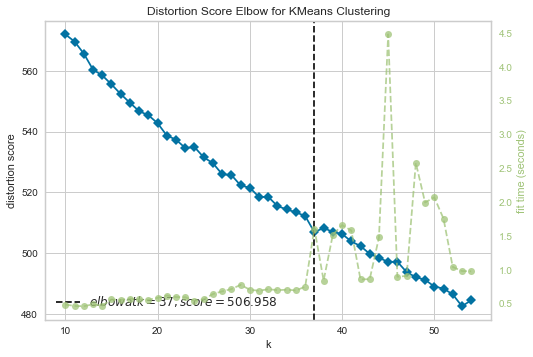

In [47]:
listings_df_en = listings_df[listings_df['name_lang_a2'] == 'en']
listings_df_en = listings_df_en.groupby('neighbourhood').agg({'name':'sum'})
listings_df_en.name = listings_df_en.name.apply(lambda x: x.lower())
name_df, name_labels = get_clustered_text_df_labels(listings_df_en.name, emb_dic, True, 'name')

In [48]:
name_df.fillna(0, inplace = True)
pickle_out = open(".\data\\name_df.pickle","wb")
pickle.dump(name_df, pickle_out)
pickle_out.close()
pickle_out = open(".\data\\name_labels.pickle","wb")
pickle.dump(name_labels, pickle_out)
pickle_out.close()

In [49]:
pickle_out = open(".\data\\name_df.pickle","rb")
name_df = pickle.load(pickle_out)
pickle_out.close()
pickle_out = open(".\data\\name_labels.pickle","rb")
name_labels = pickle.load(pickle_out)
pickle_out.close()

In [50]:
name_df.columns=name_labels

In [67]:
def filter_low_noise(df, q):
    df_v = df.copy()
    df_rq = df_v.quantile(q, axis=1)
    df_v = df_v.apply(lambda x: x - df_rq)
    df_v = df_v.applymap(lambda x: 0 if x < 0 else x)
    df_v = df_v.apply(lambda x: x/x.sum(), axis = 1)
    df_v = df_v.apply(lambda x: x-x.min(), axis = 1)
    return df_v

def filter_high_noise(df, q):
    df_v = df.copy()
    df_rq = df_v.quantile(q, axis=1)
    for i, r in df_v.iterrows():
        for j in df.columns:
            df_v.loc[i, j] = df_v.loc[i, j] if df_v.loc[i, j] < df_rq[i] else 0
    df_v = df_v.apply(lambda x: x/x.sum(), axis = 1)
    df_v = df_v.apply(lambda x: x-x.min(), axis = 1)
    return df_v

def plot_heat_map(df):
    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1.7)
    sns.heatmap(df, annot=False)

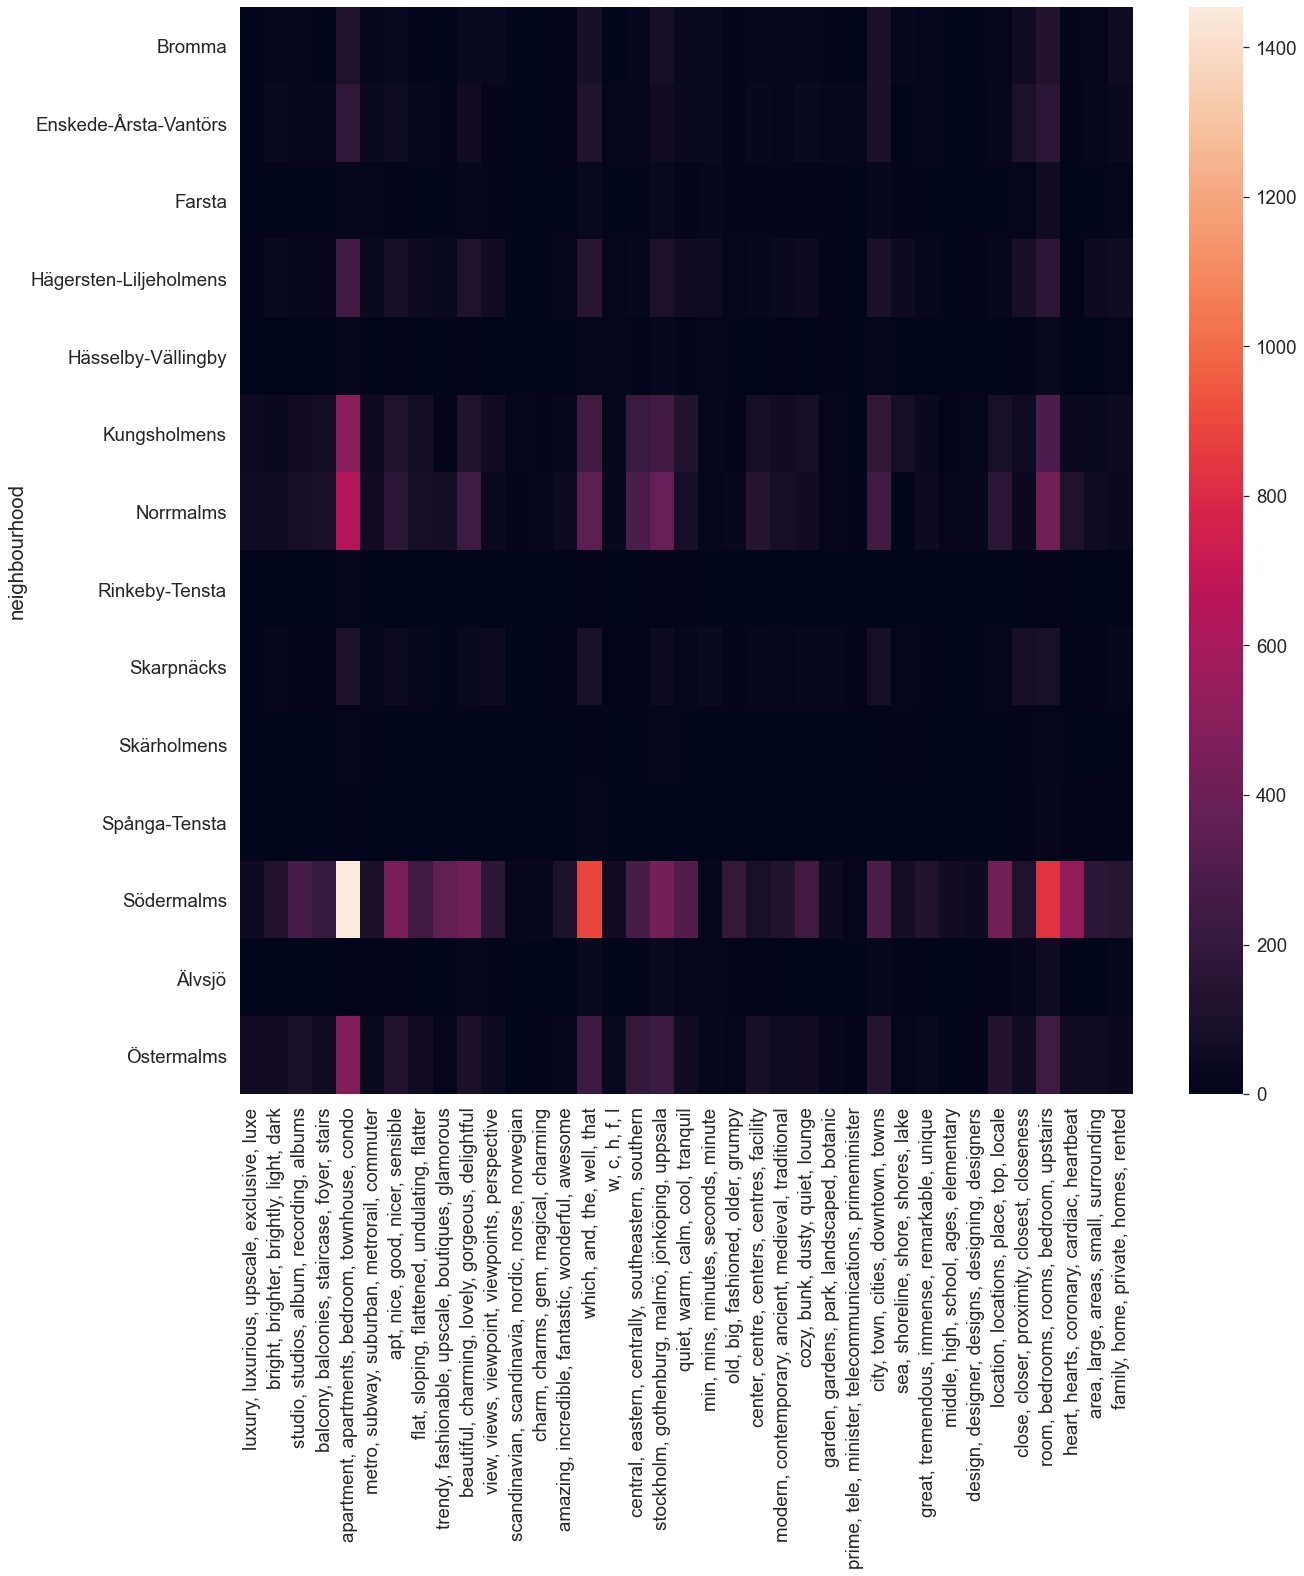

In [68]:
plot_heat_map(name_df)

In [69]:
name_df.head()

,"luxury, luxurious, upscale, exclusive, luxe","bright, brighter, brightly, light, dark","studio, studios, album, recording, albums","balcony, balconies, staircase, foyer, stairs","apartment, apartments, bedroom, townhouse, condo","metro, subway, suburban, metrorail, commuter","apt, nice, good, nicer, sensible","flat, sloping, flattened, undulating, flatter","trendy, fashionable, upscale, boutiques, glamorous","beautiful, charming, lovely, gorgeous, delightful",...,"sea, shoreline, shore, shores, lake","great, tremendous, immense, remarkable, unique","middle, high, school, ages, elementary","design, designer, designs, designing, designers","location, locations, place, top, locale","close, closer, proximity, closest, closeness","room, bedrooms, rooms, bedroom, upstairs","heart, hearts, coronary, cardiac, heartbeat","area, large, areas, small, surrounding","family, home, private, homes, rented"
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Bromma,3,12,15,2,109,17,30,11,3,38,...,24,12,1,3,12,57,134,2,15,62
Enskede-Årsta-Vantörs,1,36,16,21,183,39,56,19,7,64,...,1,12,0,2,21,106,161,0,19,39
Farsta,0,1,3,1,28,13,8,1,0,22,...,7,0,0,0,2,16,66,0,4,16
Hägersten-Liljeholmens,8,41,20,20,250,37,88,48,32,112,...,46,20,0,6,28,88,165,7,51,65
Hässelby-Vällingby,0,2,3,0,21,5,9,0,0,7,...,4,2,0,0,3,8,29,0,3,13


In [70]:
name_df_s = name_df.div(name_df.sum(axis=1), axis=0)

In [71]:
name_df_s.head()

,"luxury, luxurious, upscale, exclusive, luxe","bright, brighter, brightly, light, dark","studio, studios, album, recording, albums","balcony, balconies, staircase, foyer, stairs","apartment, apartments, bedroom, townhouse, condo","metro, subway, suburban, metrorail, commuter","apt, nice, good, nicer, sensible","flat, sloping, flattened, undulating, flatter","trendy, fashionable, upscale, boutiques, glamorous","beautiful, charming, lovely, gorgeous, delightful",...,"sea, shoreline, shore, shores, lake","great, tremendous, immense, remarkable, unique","middle, high, school, ages, elementary","design, designer, designs, designing, designers","location, locations, place, top, locale","close, closer, proximity, closest, closeness","room, bedrooms, rooms, bedroom, upstairs","heart, hearts, coronary, cardiac, heartbeat","area, large, areas, small, surrounding","family, home, private, homes, rented"
neighbourhood,,,,,,,,,,,,,,,,,,,,,
Bromma,0.002901,0.011605,0.014507,0.001934,0.105416,0.016441,0.029014,0.010638,0.002901,0.036750,...,0.023211,0.011605,0.000967,0.002901,0.011605,0.055126,0.129594,0.001934,0.014507,0.059961
Enskede-Årsta-Vantörs,0.000749,0.026946,0.011976,0.015719,0.136976,0.029192,0.041916,0.014222,0.005240,0.047904,...,0.000749,0.008982,0.000000,0.001497,0.015719,0.079341,0.120509,0.000000,0.014222,0.029192
Farsta,0.000000,0.002874,0.008621,0.002874,0.080460,0.037356,0.022989,0.002874,0.000000,0.063218,...,0.020115,0.000000,0.000000,0.000000,0.005747,0.045977,0.189655,0.000000,0.011494,0.045977
Hägersten-Liljeholmens,0.004287,0.021972,0.010718,0.010718,0.133976,0.019829,0.047160,0.025723,0.017149,0.060021,...,0.024652,0.010718,0.000000,0.003215,0.015005,0.047160,0.088424,0.003751,0.027331,0.034834
Hässelby-Vällingby,0.000000,0.009009,0.013514,0.000000,0.094595,0.022523,0.040541,0.000000,0.000000,0.031532,...,0.018018,0.009009,0.000000,0.000000,0.013514,0.036036,0.130631,0.000000,0.013514,0.058559


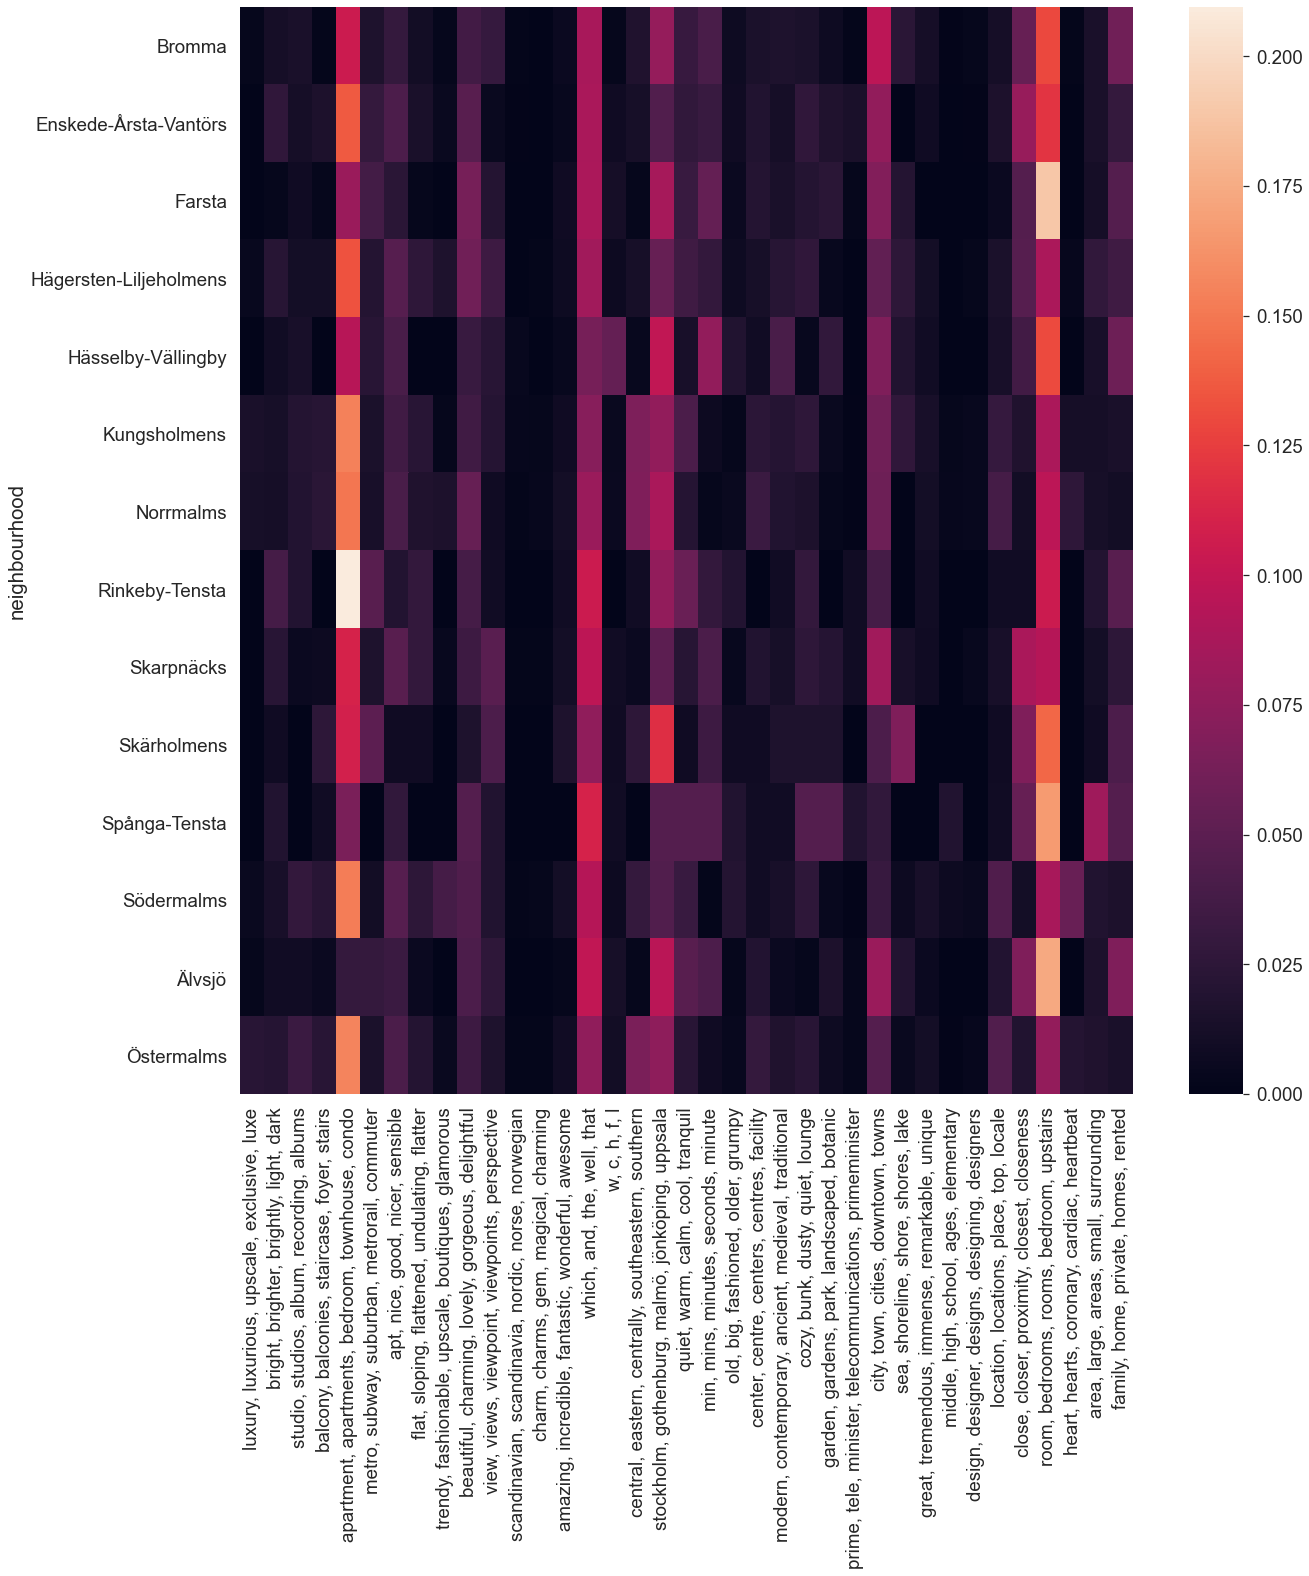

In [72]:
plot_heat_map(name_df_s)

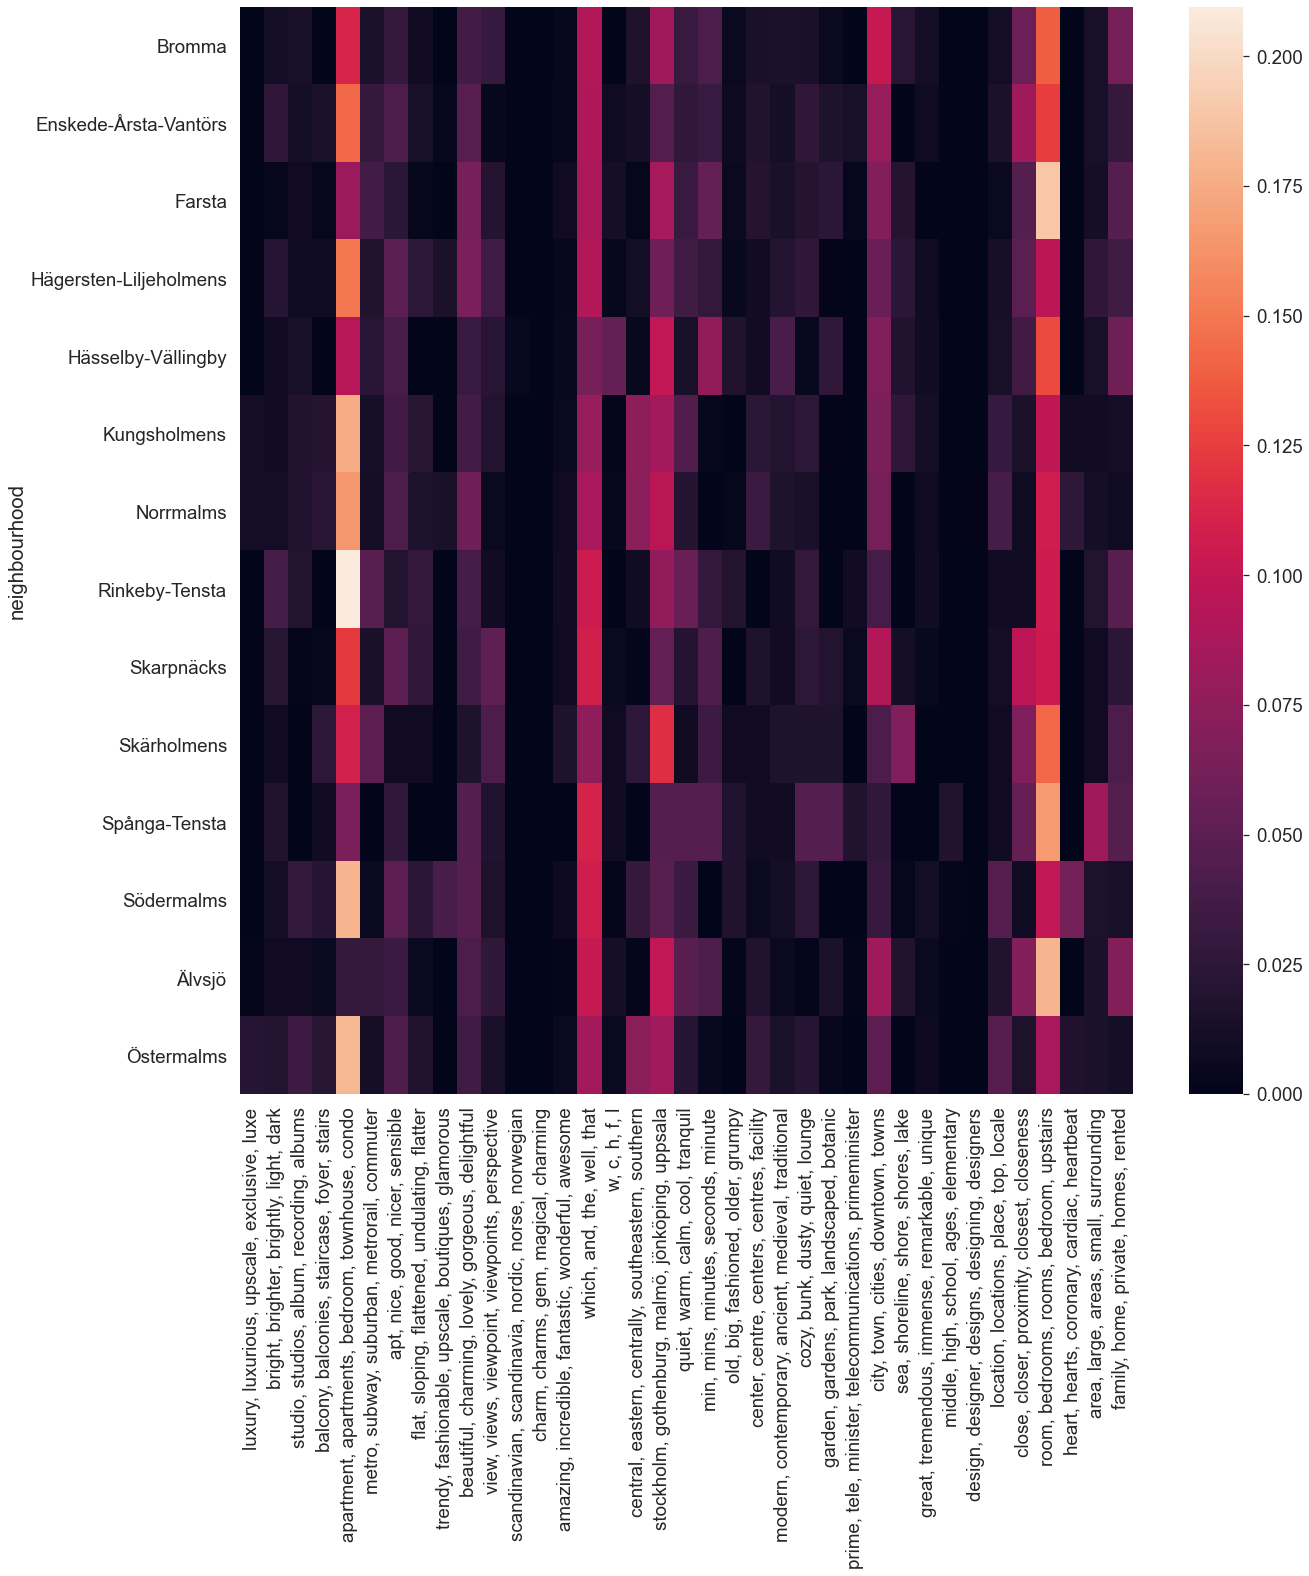

In [73]:
plot_heat_map(filter_low_noise(name_df_s, .15))

In [74]:
name_labels

['luxury, luxurious, upscale, exclusive, luxe',
 'bright, brighter, brightly, light, dark',
 'studio, studios, album, recording, albums',
 'balcony, balconies, staircase, foyer, stairs',
 'apartment, apartments, bedroom, townhouse, condo',
 'metro, subway, suburban, metrorail, commuter',
 'apt, nice, good, nicer, sensible',
 'flat, sloping, flattened, undulating, flatter',
 'trendy, fashionable, upscale, boutiques, glamorous',
 'beautiful, charming, lovely, gorgeous, delightful',
 'view, views, viewpoint, viewpoints, perspective',
 'scandinavian, scandinavia, nordic, norse, norwegian',
 'charm, charms, gem, magical, charming',
 'amazing, incredible, fantastic, wonderful, awesome',
 'which, and, the, well, that',
 'w, c, h, f, l',
 'central, eastern, centrally, southeastern, southern',
 'stockholm, gothenburg, malmö, jönköping, uppsala',
 'quiet, warm, calm, cool, tranquil',
 'min, mins, minutes, seconds, minute',
 'old, big, fashioned, older, grumpy',
 'center, centre, centers, centres